In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod

import torch
import torch.nn as nn
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from torch import optim
from utils.dataset import NCDFDatasets
from utils.trainer import Trainer
from utils.trainer import Tester
from convlstm import ConvLSTM

Load specific variables for each dataset

In [3]:
version = 1
data_path = '../../../data/dataset-ucar-1979-2015-seq5-ystep5.nc'
dataset_type = 'chirps'
param = {'layer_size': 3, 'kernel_size': 5, 'hidden_dim': 32}

In [4]:

#util = Util('STConvS2S', version=version, dataset_type=dataset_type)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [5]:
print(torch.version.cuda)

10.1


Seed

In [6]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [7]:
def init_seed(seed):
    np.random.seed(seed)

In [8]:
init_seed = init_seed(seed)

Hyperparameters

In [9]:
epochs = 50
batch_size = 25
validation_split = 0.2
test_split = 0.2
layer_size = param['layer_size']
kernel_size = param['kernel_size']
hidden_dim = param['hidden_dim']
weights = [0.9, 0.1]

Loading the dataset

In [10]:
dataset = xr.open_dataset(data_path)
dataset

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 32, lon: 32, sample: 54047, time: 5)
Coordinates:
  * lat      (lat) int32 -54 -52 -50 -48 -46 -44 -42 -40 ... -6 -4 -2 0 2 4 6 8
  * lon      (lon) int32 278 280 282 284 286 288 290 ... 330 332 334 336 338 340
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have air temperature values and are separable...

In [11]:
data = NCDFDatasets(dataset, val_split = validation_split, test_split = test_split, data_type='Reconstruction')
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [12]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("Removed : ", train_data.removed.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("Removed : ", val_data.removed.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)
print("Removed : ", test_data.removed.shape)

-----Train-----
X :  torch.Size([32429, 1, 10, 32, 32])
Y :  torch.Size([32429, 1, 10, 32, 32])
Removed :  torch.Size([32429])
-----Val-----
X :  torch.Size([10809, 1, 10, 32, 32])
Y :  torch.Size([10809, 1, 10, 32, 32])
Removed :  torch.Size([10809])
-----Test-----
X :  torch.Size([10809, 1, 10, 32, 32])
Y :  torch.Size([10809, 1, 10, 32, 32])
Removed :  torch.Size([10809])


In [13]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

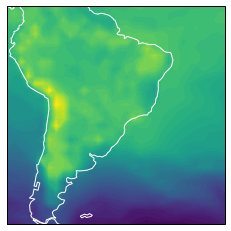

In [14]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.y[0, 0, 0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

Creating the model

In [15]:
class STConvLSTM(nn.Module):
    
    def __init__(self, layer_size, kernel_size, input_size, hidden_dim):
        super(STConvLSTM, self).__init__()
        
        self.conv_lstm_layer = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        
        input_dim=1
        for i in range(layer_size):
            self.conv_lstm_layer.append(ConvLSTM(input_size=input_size, input_dim=input_dim, hidden_dim=hidden_dim,
                                                kernel_size=(kernel_size, kernel_size),
                                                 num_layers=1, batch_first=True, bias=False, return_all_layers=True))
            self.relu_layers.append(nn.ReLU())
            self.bn_layers.append(nn.BatchNorm3d(hidden_dim))
            input_dim = hidden_dim
            
        self.final_conv = nn.Conv3d(in_channels=hidden_dim, out_channels=1, 
                                    kernel_size=(1,1,1), padding=0)
        
    def forward(self, x):
        for convlstm, relu, bn in zip(self.conv_lstm_layer, self.relu_layers, self.bn_layers):
            x, h = convlstm(x)
            x = bn(x[0])
            x = relu(x)
            
        out = self.final_conv(x)
        return out

In [16]:
class WeightedRMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y, removed):
        #y : 25 x ch x time x lat x lon
        #removed : 25
        batch, ch, time, lat, lon = yhat.shape
        cumulative_loss = 0
        for i in range(batch):
            for j in range(time):
                weight = weights[0] if removed[i] == j else (weights[1]/(time-1))
                cumulative_loss += self.mse(yhat[i,:,j,:,:], y[i,:,j,:,:]) * weight
        return torch.sqrt((cumulative_loss / (batch))+ self.eps)

In [17]:
model = STConvLSTM(layer_size, kernel_size, input_size=(train_data.x.shape[3], train_data.x.shape[4]), hidden_dim=hidden_dim).to(device)
criterion = WeightedRMSELoss()
opt_params = {'lr': 0.001, 
              'alpha': 0.9, 
              'eps': 1e-6}
optimizer = torch.optim.RMSprop(model.parameters(), **opt_params)

Training the model

In [18]:
model_path = os.path.join('../../../models/CFSR/Reconstruction/ConvLSTM-2' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, model_path, cut_output=False, recurrent_model=False, is_reconstruction=True)


In [19]:
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 5.187082
Val Avg. Loss: 3.141771
=> Saving a new best
Train - Epoch 1, Epoch Loss: 2.316067
Val Avg. Loss: 2.851670
=> Saving a new best
Train - Epoch 2, Epoch Loss: 2.236788
Val Avg. Loss: 2.528874
=> Saving a new best
Train - Epoch 3, Epoch Loss: 2.199389
Val Avg. Loss: 3.405974
Train - Epoch 4, Epoch Loss: 2.179097
Val Avg. Loss: 2.616836
Train - Epoch 5, Epoch Loss: 2.160942
Val Avg. Loss: 2.651216
Train - Epoch 6, Epoch Loss: 2.148389
Val Avg. Loss: 2.506367
=> Saving a new best


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001D1D1C64D08>
Traceback (most recent call last):
  File "c:\users\mario\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "c:\users\mario\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "c:\users\mario\anaconda3\envs\pytorch\lib\multiprocessing\process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "c:\users\mario\anaconda3\envs\pytorch\lib\multiprocessing\popen_spawn_win32.py", line 104, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
epochs = np.arange(1,len(val_losses))
plt.figure(figsize=(15,10)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

Evaluating the model

In [21]:
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
model.eval()
with torch.no_grad():
    for i, (x, y, removed) in enumerate(test_loader):
        x,y,removed = x.to(device), y.to(device), removed.to(device)
        output = model(x)
        loss = criterion(output, y, removed)
        batch_test_loss += loss.detach().item()
test_loss = batch_test_loss/len(test_loader)
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S WeightedRMSELoss: 2.2024


In [ ]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

In [19]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
def report_regression_results(y_true, y_pred):
    # Print multiple regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    adjusted_r2 =  1.0 - ( mse / y_true.var() )
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('Adjusted r2: ', round(adjusted_r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    # save a plot with the residuals
    plt.scatter(y_pred,(y_true - y_pred),edgecolors='black')
    plt.title('Fitted vs. residuals plot')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()
    f.savefig("report-experiment1.pdf", bbox_inches='tight')
    
def report_explained_variance(y_true, y_pred):
    batch, ch, time, lat, lon = y_true.shape
    explained_variance = 0
    for i in range(batch):
        for j in range(time):
            explained_variance += metrics.explained_variance_score(y_true[i,0,j,:,:], y_pred[i,0,j,:,:])
    return explained_variance / (batch*time)

def report_r2(y_true, y_pred):
    batch, ch, time, lat, lon = y_true.shape
    r2 = 0
    ar2 = 0
    for i in range(batch):
        for j in range(time):
            mse = metrics.mean_squared_error(y_true[i,0,j,:,:], y_pred[i,0,j,:,:]) 
            r2 += metrics.r2_score(y_true[i,0,j,:,:], y_pred[i,0,j,:,:])
            ar2 +=  1.0 - ( mse / y_true[i,0,j,:,:].var() )
    r2 = r2/(batch*time)
    ar2 = ar2/(batch*time)
    return r2, ar2

def plot_residual_fitted(y_true, y_pred):
    plt.scatter(y_pred,(y_true - y_pred), alpha=0.5)
    plt.title('STConvS2S')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()

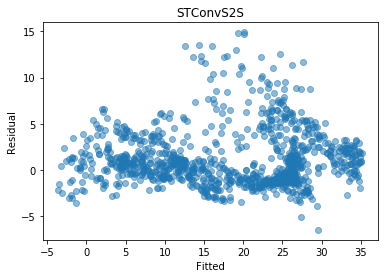

STConvS2S: 2.2369
Explained variance:  0.9389
r2:  0.913
ar2:  0.9217


In [20]:
trainer.path = '../../../models/CFSR/5_step/ConvLSTM_m04d15-h13m26s42.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
batch_explained_variance = 0.0
batch_r2 = 0.0
batch_ar2 = 0.0
model.eval()
y_true = None
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)
        y_true = y.cpu().numpy()
        y_pred = output.cpu().numpy()
        if (i == 0):
            plot_residual_fitted(y_true[0,0,0,:,:], y_pred[0,0,0,:,:])
        batch_test_loss += loss.detach().item()
        batch_explained_variance += report_explained_variance(y_true, y_pred)
        r2, ar2 = report_r2(y_true, y_pred)
        batch_r2 += r2
        batch_ar2 += ar2
        
test_loss = batch_test_loss/len(test_loader)
explained_variance = batch_explained_variance/len(test_loader)
r2 = batch_r2/len(test_loader)
ar2 = batch_ar2/len(test_loader)
print(f'STConvS2S: {test_loss:.4f}')
print('Explained variance: ', round(explained_variance,4))
print('r2: ', round(r2,4))
print('ar2: ', round(ar2,4))